In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve
from scipy import stats

Data prep

In [11]:
df = pd.read_csv("our data/Art1.csv")
df.head()

,Time:128Hz,Epoch,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Event Id,Event Date,Event Duration
0,0.000000,0,4168.974121,4152.436035,4161.025879,4124.358887,4158.205078,4162.948730,4162.436035,4163.205078,4168.589844,4166.666504,4225.897461,4172.051270,4192.948730,4170.897461,NaN,NaN,NaN
1,0.007812,0,4171.794922,4157.436035,4163.974121,4132.948730,4156.666504,4164.102539,4159.358887,4164.743652,4163.205078,4167.563965,4217.307617,4167.948730,4186.025879,4173.077148,NaN,NaN,NaN
2,0.015625,0,4174.487305,4159.743652,4168.589844,4139.615234,4159.615234,4161.666504,4161.794922,4166.794922,4160.128418,4167.051270,4220.000000,4166.794922,4184.743652,4170.769043,NaN,NaN,NaN
3,0.023438,0,4161.410156,4153.589844,4161.282227,4134.871582,4161.666504,4162.563965,4164.358887,4164.743652,4160.641113,4165.769043,4209.871582,4155.769043,4179.230957,4161.153809,NaN,NaN,NaN
4,0.031250,1,4147.563965,4148.333496,4156.282227,4136.794922,4161.794922,4163.333496,4162.436035,4162.307617,4166.538574,4165.128418,4197.948730,4147.179688,4173.589844,4151.153809,NaN,NaN,NaN


In [12]:
# Define input and output directories
input_folder = "our data"  # Replace with the path to your source folder
output_folder = "ourdata_prepared"  # Replace with the path to your target folder

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Processing parameters
sampling_rate = 128  # 128 Hz timescale
cut_time_seconds = 4.5  # Time to cut in seconds
rows_to_cut = int(sampling_rate * cut_time_seconds)  # Number of rows to cut

# Loop through all CSV files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Process only CSV files
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Read the CSV file
        df = pd.read_csv(input_path)

        # Cut the first 4.5 seconds (first `rows_to_cut` rows)
        df = df.iloc[rows_to_cut:]
        
        # Drop the first 2 columns
        df = df.iloc[:, 2:]

        # Drop the last 3 columns
        df = df.iloc[:, :-3]

        # Save the processed file to the output folder
        df.to_csv(output_path, index=False)

        print(f"Processed and saved: {filename}")

print("All files processed successfully!")


Processed and saved: Art1.csv
Processed and saved: Art10.csv
Processed and saved: Art11.csv
Processed and saved: Art12.csv
Processed and saved: Art13.csv
Processed and saved: Art14.csv
Processed and saved: Art15.csv
Processed and saved: Art16.csv
Processed and saved: Art17.csv
Processed and saved: Art18.csv
Processed and saved: Art19.csv
Processed and saved: Art2.csv
Processed and saved: Art20.csv
Processed and saved: Art21.csv
Processed and saved: Art22.csv
Processed and saved: Art23.csv
Processed and saved: Art24.csv
Processed and saved: Art25.csv
Processed and saved: Art26.csv
Processed and saved: Art27.csv
Processed and saved: Art28.csv
Processed and saved: Art29.csv
Processed and saved: Art3.csv
Processed and saved: Art30.csv
Processed and saved: Art31.csv
Processed and saved: Art32.csv
Processed and saved: Art33.csv
Processed and saved: Art34.csv
Processed and saved: Art35.csv
Processed and saved: Art36.csv
Processed and saved: Art37.csv
Processed and saved: Art38.csv
Processed a

Testy Shapiro-Wilka dla sprawdzenia czy mamy do czynienia z rozkładem normalnym:

In [13]:
input_folder = "ourdata_prepared"  # Replace with the folder path

# Loop through all the EEG data files
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Check only CSV files
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)

        # Initialize counter for columns passing Shapiro-Wilk test
        normal_count = 0
        total_columns = len(df.columns)

        # Loop through each channel (column) in the dataframe
        for col in df.columns:
            # Perform Shapiro-Wilk test for normality
            stat, p_value = stats.shapiro(df[col])

            if p_value >= 0.05:
                normal_count += 1  # Column follows normal distribution

        # Print the result for the file
        print(f"{filename} - {normal_count}/{total_columns} columns follow normal distribution")

Art1.csv - 3/14 columns follow normal distribution
Art10.csv - 3/14 columns follow normal distribution
Art11.csv - 3/14 columns follow normal distribution
Art12.csv - 0/14 columns follow normal distribution
Art13.csv - 1/14 columns follow normal distribution
Art14.csv - 2/14 columns follow normal distribution
Art15.csv - 0/14 columns follow normal distribution
Art16.csv - 2/14 columns follow normal distribution
Art17.csv - 2/14 columns follow normal distribution
Art18.csv - 3/14 columns follow normal distribution
Art19.csv - 2/14 columns follow normal distribution
Art2.csv - 3/14 columns follow normal distribution
Art20.csv - 1/14 columns follow normal distribution
Art21.csv - 3/14 columns follow normal distribution
Art22.csv - 2/14 columns follow normal distribution
Art23.csv - 2/14 columns follow normal distribution
Art24.csv - 3/14 columns follow normal distribution
Art25.csv - 1/14 columns follow normal distribution
Art26.csv - 2/14 columns follow normal distribution
Art27.csv - 3/

Niewielka ilość danych posiada rozkład normalny, tak więc zastosujemy inną metodę normalizacji niż standaryzacja Z. Zastosowaliśmy algorytm RobustScaler

In [14]:
from sklearn.preprocessing import RobustScaler
input_folder = "ourdata_prepared"
output_folder = "ourdata_scaled"
# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Check only CSV files
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)

        # Apply Robust Scaling
        scaler = RobustScaler()
        df_scaled = scaler.fit_transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        
        output_filepath = os.path.join(output_folder, filename)
        df_scaled.to_csv(output_filepath, index=False)
        print(f"Processed and saved: {filename}")      

Processed and saved: Art1.csv
Processed and saved: Art10.csv
Processed and saved: Art11.csv
Processed and saved: Art12.csv
Processed and saved: Art13.csv
Processed and saved: Art14.csv
Processed and saved: Art15.csv
Processed and saved: Art16.csv
Processed and saved: Art17.csv
Processed and saved: Art18.csv
Processed and saved: Art19.csv
Processed and saved: Art2.csv
Processed and saved: Art20.csv
Processed and saved: Art21.csv
Processed and saved: Art22.csv
Processed and saved: Art23.csv
Processed and saved: Art24.csv
Processed and saved: Art25.csv
Processed and saved: Art26.csv
Processed and saved: Art27.csv
Processed and saved: Art28.csv
Processed and saved: Art29.csv
Processed and saved: Art3.csv
Processed and saved: Art30.csv
Processed and saved: Art31.csv
Processed and saved: Art32.csv
Processed and saved: Art33.csv
Processed and saved: Art34.csv
Processed and saved: Art35.csv
Processed and saved: Art36.csv
Processed and saved: Art37.csv
Processed and saved: Art38.csv
Processed a

In [15]:
df = pd.read_csv("ourdata_scaled/Art1.csv")
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.680217,-0.247278,-1.194151,-0.206928,-0.323513,-1.090893,0.044844,-0.391290,0.391290,0.407475,-0.846396,-0.394776,-0.533710,-0.368726
1,-0.607901,-0.326989,-1.110648,-0.226733,-0.470595,-1.227320,0.314591,-0.391290,0.260970,1.185049,-0.591461,-0.265255,-0.453481,-0.404328
2,-0.802246,-0.345107,-1.269305,-0.193074,-0.529405,0.545533,0.224561,0.434675,-0.913065,0.407475,-0.792858,-0.349936,-0.520334,-0.465353
3,-1.123148,-0.341485,-1.423796,-0.123765,0.264703,1.045533,0.808900,1.347740,0.217420,-0.222144,-1.086039,-0.603988,-0.660728,-0.620477
4,-1.145750,-0.397641,-1.519830,-0.141586,0.176543,-0.863747,-0.404450,0.086935,0.565160,0.851763,-0.978971,-0.696144,-0.669640,-0.727283


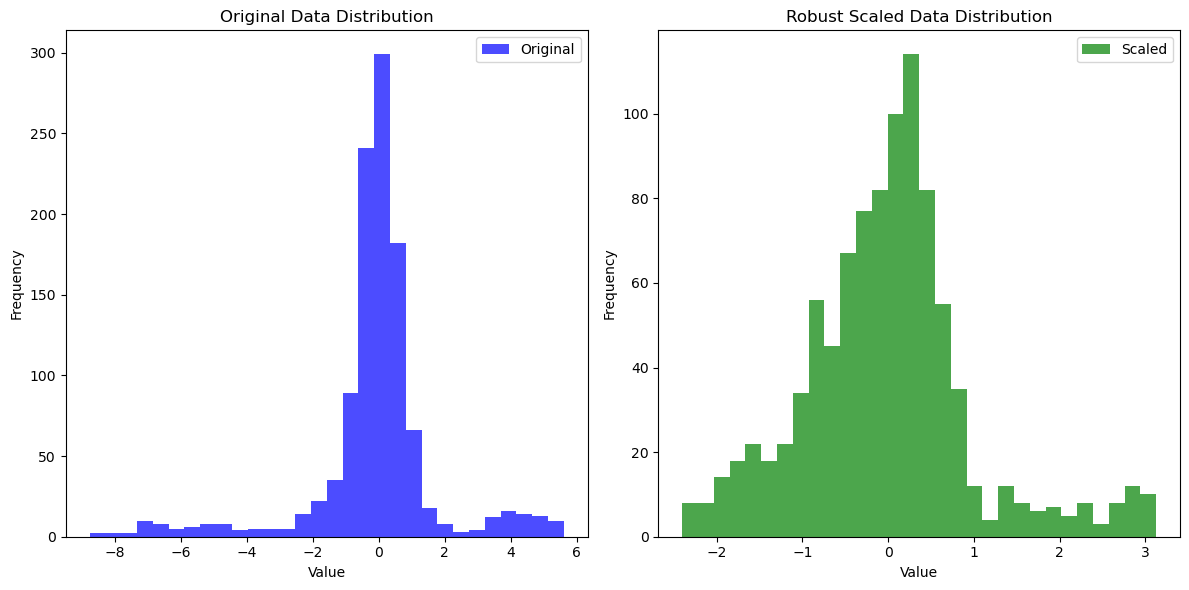

In [16]:
# Plot histograms for a sample column before and after scaling
column_original = df.iloc[:, 0]
column_scaled = df_scaled.iloc[:, 0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(column_original, bins=30, alpha=0.7, color='blue', label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(column_scaled, bins=30, alpha=0.7, color='green', label='Scaled')
plt.title("Robust Scaled Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

Jak widać na wykresie zmieniła się zarówno dystrybucja danych, jak i same wartości zostały odpowiednio przeskalowane

In [17]:
df_scaled.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.514754,0.012160,-1.821489,-0.187530,0.095221,-0.439976,1.214227,1.639756,1.388619,-0.968817,-0.027175,-0.131904,-0.113055,0.001370
1,-0.499692,0.014595,-1.839777,-0.296142,-0.047610,-0.280012,-0.214363,0.759939,-0.333192,-0.687574,-0.058229,-0.194556,-0.092632,-0.099862
2,-0.371630,0.087544,-1.832621,-0.279169,0.261903,-0.560024,-0.214363,1.039756,-1.221917,-0.593787,-0.073759,-0.224233,-0.010942,0.036934
3,-0.323918,0.087544,-1.821091,-0.280869,0.190532,-1.519957,-1.500000,-0.520030,-0.666596,-0.937515,-0.002330,-0.156633,0.091176,0.190153
4,-0.399248,0.017022,-1.817911,-0.291049,0.428584,-0.560024,-1.071409,-0.919878,0.222128,0.218757,0.000775,-0.097278,0.110139,0.119015


Here’s how the class is structured:

Feature Extractor:

A CNN extracts spatial features from EEG channels.
An RNN processes sequential (temporal) features for variable-length input.
Similarity Metric:

The outputs from the feature extractors for both inputs are compared using a distance metric (e.g., Euclidean or cosine similarity).

In [18]:
class SiameseEEGNet(nn.Module):
    def __init__(self, input_channels):
        super(SiameseEEGNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2),  # Convolution layer
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Downsample by 2
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
        )

        # Manually calculate the flattened size after convolution and pooling
        # Assuming input length is 128, and we're downsampling by 2 twice (via MaxPool1d)
        self.flattened_size = 128 // 2 // 2 * 128  # Output size of the feature extractor
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward_one_branch(self, x):
        """
        Forward pass for one branch of the Siamese network.
        """
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten for fully connected layer
        embedding = self.fc(features)  # Generate embedding
        return embedding

    def forward(self, x1, x2):
        """
        Forward pass for the Siamese network.
        """
        embedding1 = self.forward_one_branch(x1)
        embedding2 = self.forward_one_branch(x2)
        return embedding1, embedding2


Taki model uczymy w specyficzny sposób: Dostarczamy danych treningowych od osoby właściwej, a także dane niewłaściwe od innych oraz udające osobę właściwą inne osoby.

Loss function for this network

In [19]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, label):
        """
        Contrastive Loss
        :param embedding1: Embedding from branch 1
        :param embedding2: Embedding from branch 2
        :param label: 1 if same class, 0 if different class
        :return: Loss value
        """
        euclidean_distance = F.pairwise_distance(embedding1, embedding2)
        loss = label * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

Key Loss Function: Contrastive Loss
The contrastive loss is widely used in Siamese networks. It ensures that:

The embeddings of similar pairs are closer in the embedding space.
The embeddings of dissimilar pairs are farther apart, with a margin to encourage separation.

Initialization:

At the start, embeddings are randomly distributed in the feature space.

Forward Pass:

For a given pair of inputs, the network computes embeddings

𝑒1 and 𝑒2.

The Euclidean distance  𝐷 is calculated.
The contrastive loss measures how well the embeddings reflect the similarity/dissimilarity of the pair.

Backward Pass:

Gradients of the loss with respect to the network parameters are computed.
For similar pairs (𝑦=1):
The network adjusts weights to reduce 𝐷.
For dissimilar pairs (y=0):

If

𝐷 < 𝑚, the network adjusts weights to increase 𝐷.

If

𝐷 > 𝑚, no gradient is propagated for dissimilar pairs.

Optimization:

Using an optimizer like Adam or SGD, the network updates weights to minimize the contrastive loss.

Embedding Separation:

The network learns to position embeddings of similar inputs closer and dissimilar inputs farther apart.
The embedding space becomes more structured, with distinct clusters for each class.
Improved Pairwise Distinction:

The Euclidean distance 
𝐷
 becomes a reliable metric for class similarity.
Smaller 
𝐷
 for similar pairs, and larger 
𝐷
 for dissimilar pairs.
Margin Enforcement:

For dissimilar pairs, the network ensures embeddings are separated by at least the margin 
𝑚.
Generalization:

With sufficient data and training, the network generalizes to unseen pairs, correctly predicting similarity or dissimilarity.

STARY MODEL:

class EnhancedAutoencoder(nn.Module):
    def __init__(self, in_channels):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(1, 5), padding=(0, 2)),  # (N, 32, T, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension (N, 32, T/2, C)
            nn.Conv2d(32, 64, kernel_size=(1, 5), padding=(0, 2)),  # (N, 64, T/2, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension further (N, 64, T/4, C)
            nn.Conv2d(64, 128, kernel_size=(1, 5), padding=(0, 2)),  # (N, 128, T/4, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension further (N, 128, T/8, C)
        )
        
        # Bottleneck (latent space)
        self.bottleneck = nn.Conv2d(128, 256, kernel_size=(1, 5), padding=(0, 2))  # (N, 256, T/8, C)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(1, 5), padding=(0, 2)),  # (N, 128, T/4, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=(1, 5), padding=(0, 2)),  # (N, 64, T/2, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=(1, 5), padding=(0, 2)),  # (N, 32, T, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(32, in_channels, kernel_size=(1, 5), padding=(0, 2)),  # (N, in_channels, T, C)
            nn.Tanh()  # Tanh for output in range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

Sorting the data into training and validation datasets and folders

In [20]:
import shutil
import random

def create_datasets(data_folder, output_folder):
    # List of people
    people = ["Art", "Oli", "Tym"]
    
    # Create output directories for each person
    for person in people:
        
        # Define paths for one of the key folders to check for existing data
        branch1_train_dir = os.path.join(output_folder, f"{person}_training_branch1")
        
        # Check if the folder already exists and contains files
        if os.path.exists(branch1_train_dir) and os.listdir(branch1_train_dir):
            print(f"Skipping {person}, data already exists.")
            continue
        
        # Make directories for training, validation, and testing sets
        branch1_train_dir = os.path.join(output_folder, f"{person}_training_branch1")
        branch2_train_dir = os.path.join(output_folder, f"{person}_training_branch2")
        branch1_val_dir = os.path.join(output_folder, f"{person}_validation_branch1")
        branch2_val_dir = os.path.join(output_folder, f"{person}_validation_branch2")
        branch1_test_dir = os.path.join(output_folder, f"{person}_testing_branch1")
        branch2_test_dir = os.path.join(output_folder, f"{person}_testing_branch2")
        branch_random_test_dir = os.path.join(output_folder, f"{person}_testing_branch_random")

        os.makedirs(branch1_train_dir, exist_ok=True)
        os.makedirs(branch2_train_dir, exist_ok=True)
        os.makedirs(branch1_val_dir, exist_ok=True)
        os.makedirs(branch2_val_dir, exist_ok=True)
        os.makedirs(branch1_test_dir, exist_ok=True)
        os.makedirs(branch2_test_dir, exist_ok=True)
        os.makedirs(branch_random_test_dir, exist_ok=True)

        # Get list of all recordings for the person (Art1-Art45, Oli1-Oli45, Tym1-Tym45)
        recordings = [f"{person}{i}" for i in range(1, 46)]  
        
        # Create a list of impostor recordings (person trying to impersonate the target person)
        impostor_recordings = []
        for other_person in people:
            if other_person != person:
                for i in range(1, 4):
                    impostor_recordings.append(f"{other_person}log-{person}{i}")
        
        # Remove non-existent files (such as Olilog-Art2 if it doesn't exist)
        impostor_recordings = [file for file in impostor_recordings if os.path.exists(os.path.join(data_folder, f"{file}.csv"))]
        
        # Shuffle the list of impostor recordings to ensure randomness
        random.shuffle(impostor_recordings)
        
        # Branch 1: Training set (randomly select 38 recordings for the person)
        branch1_train_files = random.sample(recordings, 38)  # Select 38 random recordings for training
        for file in branch1_train_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_train_dir, f"{file}.csv"))
        
        # Branch 2: Training set (2 impostor files + 36 random recordings from other people)
        branch2_train_files = []
        branch2_train_files.extend(impostor_recordings[:2])  # Two impostor files
        other_people_recordings = []
        
        # Collect 36 recordings from other people
        for other_person in people:
            if other_person != person:
                other_people_recordings.extend([f"{other_person}{i}" for i in range(1, 46)])
        random.shuffle(other_people_recordings)
        branch2_train_files.extend(other_people_recordings[:36])
        
        # Copy all branch2 train files
        for file in branch2_train_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_train_dir, f"{file}.csv"))
        
        # Validation Set for Branch 1 (7 files from remaining recordings of the person, not in training set)
        remaining_recordings = list(set(recordings) - set(branch1_train_files))  # Remaining files
        branch1_val_files = random.sample(remaining_recordings, 7)  # Select 7 random recordings from remaining files
        for file in branch1_val_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_val_dir, f"{file}.csv"))
        
        # Validation Set for Branch 2 (7 random recordings from other people not in training set)
        # First, collect all recordings of other people
        other_people_recordings = []
        for other_person in people:
            if other_person != person:
                other_people_recordings.extend([f"{other_person}{i}" for i in range(1, 46)])
        
        # Remove the recordings already used in training set for branch2
        other_people_recordings = list(set(other_people_recordings) - set(branch2_train_files))
        
        # Select 7 random recordings from other people for branch2 validation
        branch2_val_files = random.sample(other_people_recordings, 7)
        
        # Copy all branch2 val files
        for file in branch2_val_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_val_dir, f"{file}.csv"))
        
        # Test Set for Branch 1 (Test recordings like Artlog1, Olilog2, etc.)
        branch1_test_files = [f"{person}log{i}" for i in range(1, 4)]
        for file in branch1_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_test_dir, f"{file}.csv"))
        
        # Test Set for Branch 2 (3 random impostor files that have not been used in training)
        branch2_test_files = random.sample(impostor_recordings[2:], 3)  # Select 3 random impostor files not used in training
        
        # Copy all branch2 test files
        for file in branch2_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_test_dir, f"{file}.csv"))
        
        # Random Test Set (Olilog-random1, Tymlog-random2, etc.)
        branch_random_test_files = [f"{person}log-random{i}" for i in range(1, 4)]
        for file in branch_random_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch_random_test_dir, f"{file}.csv"))
        
        print(f"Dataset created for {person}")

# Example usage
data_folder = "ourdata_scaled"  # Folder containing EEG CSV files (e.g., Art1.csv, Oli32.csv)
output_folder = "user_database"  # Folder to store the new datasets

create_datasets(data_folder, output_folder)


Skipping Art, data already exists.
Skipping Oli, data already exists.
Skipping Tym, data already exists.


Sliding Window Approach
The sliding window approach is a method for breaking down time-series data (such as EEG recordings) into smaller, overlapping or non-overlapping segments of fixed size. It’s particularly useful for processing data with variable lengths, as it enables uniform input sizes for machine learning models.

Window Size:

The number of time steps in each segment.
For EEG data, the window size might correspond to a specific duration, e.g., 1 second (128 samples at 128 Hz).
Step Size (Stride):

The number of time steps the window moves forward for the next segment.
If the step size is smaller than the window size, the windows overlap. If it's equal, there's no overlap.
Overlapping vs. Non-Overlapping Windows:

Overlapping: Captures more contextual information, as segments share data points.
Non-Overlapping: Simpler, but may miss transitions or subtle patterns at window boundaries.

We will use overlapping windows (the window step is smaller than window length)

In [21]:
def apply_sliding_window(data, window_length, window_step):
    """
    Applies a sliding window to the EEG data to create overlapping windows.
    """
    windows = []
    num_samples = len(data)
    
    for start in range(0, num_samples - window_length + 1, window_step):
        end = start + window_length
        window = data[start:end]
        windows.append(window)
    
    return np.array(windows)


In [22]:
def create_sliding_window_dataset_from_folders(input_folder, output_folder, window_length=128, window_step=64):
    """
    Processes the dataset using a sliding window approach for EEG data.
    The input_folder contains subfolders for each person's training, validation, and testing data.
    """
    # List of people
    people = ["Art", "Oli", "Tym"]
    
    # Iterate through each person
    for person in people:
        # Folders where the data for each person is stored
        branch1_train_dir = os.path.join(input_folder, f"{person}_training_branch1")
        branch2_train_dir = os.path.join(input_folder, f"{person}_training_branch2")
        branch1_val_dir = os.path.join(input_folder, f"{person}_validation_branch1")
        branch2_val_dir = os.path.join(input_folder, f"{person}_validation_branch2")
        
        # Test data folders
        branch1_test_dir = os.path.join(input_folder, f"{person}_testing_branch1")
        branch2_test_dir = os.path.join(input_folder, f"{person}_testing_branch2")
        branch_random_test_dir = os.path.join(input_folder, f"{person}_testing_branch_random")
        
        # Create output directories for storing sliding windows with -datawindow suffix
        person_window_dir = os.path.join(output_folder, f"{person}_datawindow")
        
        # Check if the folder already exists and contains files
        if os.path.exists(person_window_dir) and os.listdir(person_window_dir):
            print(f"Skipping {person}, data already exists.")
            continue
        os.makedirs(person_window_dir, exist_ok=True)
        
        # Process the branch1 training files
        process_directory(branch1_train_dir, person_window_dir, window_length, window_step, f"{person}_training_branch1")
        
        # Process the branch2 training files
        process_directory(branch2_train_dir, person_window_dir, window_length, window_step, f"{person}_training_branch2")
        
        # Process the branch1 validation files
        process_directory(branch1_val_dir, person_window_dir, window_length, window_step, f"{person}_validation_branch1")
        
        # Process the branch2 validation files
        process_directory(branch2_val_dir, person_window_dir, window_length, window_step, f"{person}_validation_branch2")
        
        # Process the branch1 test files
        process_directory(branch1_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch1")
        
        # Process the branch2 test files
        process_directory(branch2_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch2")
        
        # Process the random test files
        process_directory(branch_random_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch_random")

        print(f"Sliding windows created for {person}")

def process_directory(input_dir, output_dir, window_length, window_step, label_prefix):
    """
    Processes the files in a directory, applying the sliding window approach and saving the windows.
    """
    # Get all files in the directory
    files = sorted(os.listdir(input_dir))
    
    for file_name in files:
        # Ensure that the file is a CSV
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_dir, file_name)
            
            # Load EEG data from the CSV file
            df = pd.read_csv(file_path)
            eeg_data = df.to_numpy()  # Convert to numpy array
            
            # Apply sliding window to create smaller chunks
            windows = apply_sliding_window(eeg_data, window_length, window_step)
            
            # Create a new directory for this file with -datawindow suffix
            file_datawindow_dir = os.path.join(output_dir, f"{label_prefix}_datawindow")
            os.makedirs(file_datawindow_dir, exist_ok=True)
            
            # Save the windows to new files with the -datawindow{i} suffix
            for i, window in enumerate(windows):
                window_filename = f"{file_name.replace('.csv', '')}_datawindow{i}.csv"
                window_file_path = os.path.join(file_datawindow_dir, window_filename)
                window_df = pd.DataFrame(window)  # Convert window to DataFrame for saving
                window_df.to_csv(window_file_path, index=False)

# Example usage
input_folder = "user_database"  # Folder containing the training/validation directories (e.g., Art_training_branch1)
output_folder = "user_database_windowed/length384_step64"  # Folder to store the new sliding window datasets

#Tniemy dane w okienka i tworzymy okienka danych o dlugosci i skoku, 128-1 sekunda
create_sliding_window_dataset_from_folders(input_folder, output_folder, window_length=384, window_step=64)

Skipping Art, data already exists.
Skipping Oli, data already exists.
Skipping Tym, data already exists.


Przekształciliśmy wszystkie dane w okienka danych o równej długości.

In [23]:
class SiameseEEGDataset(Dataset):
    def __init__(self, folder_path, input_channels=14):
        """
        Args:
            folder_path (str): Path to the folder containing the processed data (CSV files).
            input_channels (int): Number of EEG channels (e.g., 14).
        """
        self.folder_path = folder_path
        self.file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
        self.data = []  # To store loaded data
        self.labels = []  # To store corresponding labels

        # Extract the label from the folder name
        self.label = self.extract_label_from_folder(folder_path)

        # Load all files into memory (optional, depending on dataset size)
        for file_path in self.file_paths:
            df = pd.read_csv(file_path)
            # Assuming the data needs reshaping (e.g., reshaping into (channels, time_steps))
            data = df.values.T  # Transpose if necessary to match (channels, time_steps)
            self.data.append(data)  # (input_channels, time_steps) shape
            self.labels.append(self.label)  # Assign the same label to all files in the folder

    @staticmethod
    def extract_label_from_folder(folder_path):
        """
        Extracts the label based on the folder name.
        Args:
            folder_path (str): Path to the folder containing the data.
        Returns:
            int: Label corresponding to the folder type.
        """
        folder_name = os.path.basename(folder_path)
        if "branch2" in folder_name:
            return 1  # Impostor
        else:
            return 0  # Genuine

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single EEG sample and its label.
        """
        data = torch.tensor(self.data[idx], dtype=torch.float32)
        label = self.labels[idx]
        return data, label


In [24]:
class SiamesePairDataset(Dataset):
    def __init__(self, dataloaders):
        """
        Args:
            dataloaders (dict): Dictionary containing train, validation, and test dataloaders.
        """
        self.dataloaders = dataloaders
        self.pairs = []
        self.labels = []
        self.create_pairs()

    def create_pairs(self):
        branches = list(self.dataloaders.keys())
        
        # Loop over all pairs of branches (including same and different branches)
        for i, branch1 in enumerate(branches):
            for j, branch2 in enumerate(branches):
                dataloader1 = self.dataloaders[branch1]
                dataloader2 = self.dataloaders[branch2]
                
                for x_batch1, y_batch1 in dataloader1:
                    for x_batch2, y_batch2 in dataloader2:
                        # Ensure x_batch and y_batch are tensors
                        x_batch1 = torch.tensor(x_batch1) if not isinstance(x_batch1, torch.Tensor) else x_batch1
                        x_batch2 = torch.tensor(x_batch2) if not isinstance(x_batch2, torch.Tensor) else x_batch2
                        y_batch1 = torch.tensor(y_batch1) if not isinstance(y_batch1, torch.Tensor) else y_batch1
                        y_batch2 = torch.tensor(y_batch2) if not isinstance(y_batch2, torch.Tensor) else y_batch2

                        # Check for matching batch sizes
                        min_len = min(len(x_batch1), len(x_batch2))  # Use the smallest batch size to avoid index out of range
                        
                        # Generate positive pairs (same class within the same branch)
                        if i == j:  # Same branch
                            for k in range(min_len):
                                for l in range(k + 1, min_len):
                                    if y_batch1[k] == y_batch1[l]:
                                        self.pairs.append((x_batch1[k], x_batch2[l]))  # Same data within the branch
                                        self.labels.append(1)  # Same class (genuine)
                        else:  # Different branches
                            for k in range(min_len):
                                for l in range(min_len):
                                    self.pairs.append((x_batch1[k], x_batch2[l]))  # Different branch pair
                                    self.labels.append(0)  # Different class (impostor)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x1, x2 = self.pairs[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return x1, x2, label


In [25]:
# Function to create DataLoaders for training, validation, and testing
def create_dataloaders(base_dir, person, input_channels=14, batch_size=96, shuffle=True):
    """
    Args:
        base_dir (str): Base directory containing all processed data folders.
        person (str): Person whose data we are loading.
        input_channels (int): Number of EEG channels (e.g., 14).
        batch_size (int): Batch size for DataLoader.
        shuffle (bool): Whether to shuffle the data.

    Returns:
        dict: A dictionary containing DataLoaders for training, validation, and testing.
    """
    dataloaders = {}

    # Define subdirectories for training, validation, and testing
    subdirs = {
        "train_branch1": f"{person}_training_branch1_datawindow",
        "train_branch2": f"{person}_training_branch2_datawindow",
        "val_branch1": f"{person}_validation_branch1_datawindow",
        "val_branch2": f"{person}_validation_branch2_datawindow",
        "test_branch1": f"{person}_testing_branch1_datawindow",
        "test_branch2": f"{person}_testing_branch2_datawindow",
        "test_random": f"{person}_testing_branch_random_datawindow",
    }

    # Create DataLoaders for each branch
    for key, subdir in subdirs.items():
        folder_path = os.path.join(base_dir, f"{person}_datawindow", subdir)
        if os.path.exists(folder_path):
            dataset = SiameseEEGDataset(folder_path, input_channels=input_channels)  # Use the modified dataset for EEG data
            dataloaders[key] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        else:
            print(f"Warning: Folder {folder_path} does not exist. Skipping {key}.")

    return dataloaders

# Example usage
base_dir = "user_database_windowed/length128_step64"  # Path to the main processed data folder
person = "Art"  # Specify the person for whom to load data
input_channels = 14  # Adjust based on the number of EEG channels in your dataset

# Create DataLoaders for the person's data
dataloaders = create_dataloaders(base_dir, person, input_channels=input_channels)


In [26]:
print(dataloaders)

{'train_branch1': <torch.utils.data.dataloader.DataLoader object at 0x00000277E92505E0>, 'train_branch2': <torch.utils.data.dataloader.DataLoader object at 0x00000277E92B4970>, 'val_branch1': <torch.utils.data.dataloader.DataLoader object at 0x00000277E9305AF0>, 'val_branch2': <torch.utils.data.dataloader.DataLoader object at 0x00000277E930EFD0>, 'test_branch1': <torch.utils.data.dataloader.DataLoader object at 0x00000277E9326EB0>, 'test_branch2': <torch.utils.data.dataloader.DataLoader object at 0x00000277E9335D60>, 'test_random': <torch.utils.data.dataloader.DataLoader object at 0x00000277E933B9A0>}


In [27]:
for branch_name, dataloader in dataloaders.items():
    print(f"\nChecking dataloader for branch: {branch_name}")
    batch_count = 0
    for x_batch, y_batch in dataloader:  # Unpack single data points
        print(f"Batch {batch_count + 1} Shape: x={x_batch.shape}, labels={y_batch.shape}")
        batch_count += 1

        # Optionally, stop after the first batch for faster checks
        if batch_count >= 1:
            break

    if batch_count == 0:
        print(f"Warning: No batches found in {branch_name}. Check your dataset.")
    else:
        print(f"{batch_count} batch(es) found in {branch_name}.")




Checking dataloader for branch: train_branch1
Batch 1 Shape: x=torch.Size([96, 14, 128]), labels=torch.Size([96])
1 batch(es) found in train_branch1.

Checking dataloader for branch: train_branch2
Batch 1 Shape: x=torch.Size([96, 14, 128]), labels=torch.Size([96])
1 batch(es) found in train_branch2.

Checking dataloader for branch: val_branch1
Batch 1 Shape: x=torch.Size([96, 14, 128]), labels=torch.Size([96])
1 batch(es) found in val_branch1.

Checking dataloader for branch: val_branch2
Batch 1 Shape: x=torch.Size([88, 14, 128]), labels=torch.Size([88])
1 batch(es) found in val_branch2.

Checking dataloader for branch: test_branch1
Batch 1 Shape: x=torch.Size([43, 14, 128]), labels=torch.Size([43])
1 batch(es) found in test_branch1.

Checking dataloader for branch: test_branch2
Batch 1 Shape: x=torch.Size([42, 14, 128]), labels=torch.Size([42])
1 batch(es) found in test_branch2.

Checking dataloader for branch: test_random
Batch 1 Shape: x=torch.Size([43, 14, 128]), labels=torch.Size

This output confirms that the SiameseEEGDataset is functioning correctly, and the DataLoader is successfully creating batches of data. Here’s what the output means:

Batch Shapes:

x=torch.Size([64, 14, 128]) indicates that each batch contains 64 EEG samples, each with 14 channels and 128 time steps. The batch size matches the batch_size parameter you passed during DataLoader creation.
labels=torch.Size([64]) shows that there are 64 corresponding labels for these EEG samples, which align with the batch size.
Branches:

All branches (train_branch1, train_branch2, etc.) have at least one batch. This confirms that data exists in the respective directories and the dataset is being loaded correctly.
The batch sizes for test_branch1, test_branch2, and test_random are smaller (43, 42, and 43), likely because the dataset size for these branches is not divisible by the batch size (64). This is expected behavior.

In [28]:
def create_pair_datasets(dataloaders, batch_size=96):
    """
    Create separate pair datasets for training, validation, and testing.
    Args:
        dataloaders (dict): Dictionary containing train, validation, and test DataLoaders.
        batch_size (int): Batch size for DataLoader.
    
    Returns:
        dict: A dictionary containing separate DataLoader objects for training, validation, and testing.
    """
    pair_datasets = {}

    # Define subsets of dataloaders for each category
    subsets = {
        "train": ["train_branch1", "train_branch2"],
        "val": ["val_branch1", "val_branch2"],
        "test": ["test_branch1", "test_branch2", "test_random"],
    }

    for key, branches in subsets.items():
        # Filter dataloaders to include only the branches for this subset
        filtered_dataloaders = {branch: dataloaders[branch] for branch in branches if branch in dataloaders}
        
        # Create a SiamesePairDataset using only the filtered dataloaders
        pair_dataset = SiamesePairDataset(filtered_dataloaders)
        
        # Wrap the SiamesePairDataset with DataLoader for batching
        pair_datasets[key] = DataLoader(pair_dataset, batch_size=batch_size, shuffle=True)

    return pair_datasets


In [29]:
pair_datasets = create_pair_datasets(dataloaders)

# Check each paired dataset with batching
for dataset_type, pair_dataset in pair_datasets.items():
    print(f"\nChecking pairs in {dataset_type} dataset:")
    for x1, x2, y in pair_dataset:
        print(f"x1 Shape: {x1.shape}, x2 Shape: {x2.shape}, Label: {y}")
        break  # Check only the first batch



Checking pairs in train dataset:
x1 Shape: torch.Size([96, 14, 128]), x2 Shape: torch.Size([96, 14, 128]), Label: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

Checking pairs in val dataset:
x1 Shape: torch.Size([96, 14, 128]), x2 Shape: torch.Size([96, 14, 128]), Label: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0])

Checking pairs in test dataset:
x1 Shape: torch.Size([96, 14, 128]), x2 Shape: torch.Size([96, 14, 128]), Label: tensor([0, 1, 0,

Batch Shapes:

x1 Shape: torch.Size([64, 14, 128]) and x2 Shape: torch.Size([64, 14, 128]) indicate that each batch contains 64 pairs of EEG data samples. Each sample has 14 channels and 128 time steps.
Labels Shape: torch.Size([64]) shows that there are 64 labels corresponding to the 64 pairs. Each label specifies whether the pair is from the same class (1) or different classes (0).

Consistent Batch Size:

All batches have the same number of pairs (64), which matches the batch_size you specified when creating the DataLoader for SiamesePairDataset.

Multiple Batches:

The presence of multiple batches (e.g., Batch 1 and Batch 2) confirms that your SiamesePairDataset and its DataLoader are properly generating and iterating through the data pairs.

Ostatnie Sprawdzenie:

In [30]:
for branch_name, dataloader in dataloaders.items():
    dataset = dataloader.dataset
    dataset_size = len(dataset)  # Total samples in the dataset

    total_samples = 0
    for x_batch, y_batch in dataloader:
        total_samples += x_batch.size(0)

    print(f"{branch_name}:")
    print(f"  Dataset size: {dataset_size}")
    print(f"  Dataloader samples: {total_samples}")
    if dataset_size != total_samples:
        print(f"  Mismatch detected in {branch_name}!")


train_branch1:
  Dataset size: 505
  Dataloader samples: 505
train_branch2:
  Dataset size: 527
  Dataloader samples: 527
val_branch1:
  Dataset size: 96
  Dataloader samples: 96
val_branch2:
  Dataset size: 88
  Dataloader samples: 88
test_branch1:
  Dataset size: 43
  Dataloader samples: 43
test_branch2:
  Dataset size: 42
  Dataloader samples: 42
test_random:
  Dataset size: 43
  Dataloader samples: 43


The pair_dataset contains pairs of EEG samples and corresponding labels, which are generated based on the original EEG data from the dataloaders for each branch (train_branch1, train_branch2, etc.). Here's how the pair_dataset is constructed:

Contents of pair_dataset

Pairs of EEG Samples (x1 and x2):

Each pair consists of two EEG samples (x1 and x2).

These samples are extracted from the original data loaded via the SiameseEEGDataset for each branch.

For example, if branch1 contains EEG sample A and branch2 contains EEG sample B, a positive pair would be (A, A) with a label 1, and a negative pair could be (A, B) with a label 0.

Labels (0 or 1):

Label 1: Indicates that the two samples in the pair belong to the same class (e.g., both from "genuine" data or the same person).

Label 0: Indicates that the two samples in the pair belong to different classes (e.g., one from "genuine" data and the other from "impostor" data).

How Is pair_dataset Created?

The SiamesePairDataset generates pairs by iterating through each branch's DataLoader:

It takes batches of EEG data (x_batch) and their labels (y_batch) from each branch.

For each batch:

Positive pairs: Pairs are created from samples with the same label in the batch.

Negative pairs: Pairs are created from samples with different labels in the batch.

For example:

Pairs generated:

Positive: (A1, A2), (B1, B2) with label 1
Negative: (A1, B1), (A2, B3) with label 0

Załadowaliśmy dane do pamięci

Initialize the model

In [31]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseEEGNet(input_channels=14).to(device)
criterion = ContrastiveLoss(margin=1.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Training loop

In [32]:
def train(model, pair_datasets, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    train_losses = []
    val_losses = []

    try:
        for epoch in range(num_epochs):
            model.train()
            running_train_loss = 0.0

            # Use tqdm for the training loop
            with tqdm(total=len(pair_datasets['train']), desc=f"Epoch {epoch+1}/{num_epochs} Train") as pbar:
                for x1, x2, label in pair_datasets['train']:
                    # Ensure the data is moved to the correct device
                    x1, x2, label = x1.to(device), x2.to(device), label.to(device)

                    optimizer.zero_grad()  # Zero the gradients

                    # Forward pass
                    embedding1, embedding2 = model(x1, x2)

                    # Compute loss
                    loss = criterion(embedding1, embedding2, label)
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update model parameters

                    running_train_loss += loss.item()

                    # Update progress bar
                    pbar.set_postfix({'Loss': loss.item()})
                    pbar.update(1)

            avg_train_loss = running_train_loss / len(pair_datasets['train'])
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                # Use tqdm for the validation loop
                with tqdm(total=len(pair_datasets['val']), desc=f"Epoch {epoch+1}/{num_epochs} Val") as pbar_val:
                    for x1, x2, label in pair_datasets['val']:
                        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
                        embedding1, embedding2 = model(x1, x2)
                        loss = criterion(embedding1, embedding2, label)
                        running_val_loss += loss.item()

                        # Update progress bar for validation
                        pbar_val.set_postfix({'Loss': loss.item()})
                        pbar_val.update(1)

            avg_val_loss = running_val_loss / len(pair_datasets['val'])
            val_losses.append(avg_val_loss)

            # Print loss for this epoch
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving model...")
        torch.save(model.state_dict(), "model_interrupted.pth")
        print("Model saved.")
    
    torch.save(model.state_dict(), "model_saved.pth")
    print("Model saved.")
    return train_losses, val_losses

# Example usage:
train_losses, val_losses = train(model, pair_datasets, criterion, optimizer, num_epochs=10, device='cpu')


Epoch 1/10 Train:   3%|▎         | 210/7642 [00:13<07:53, 15.69it/s, Loss=0.254]

Training interrupted. Saving model...
Model saved.
Model saved.


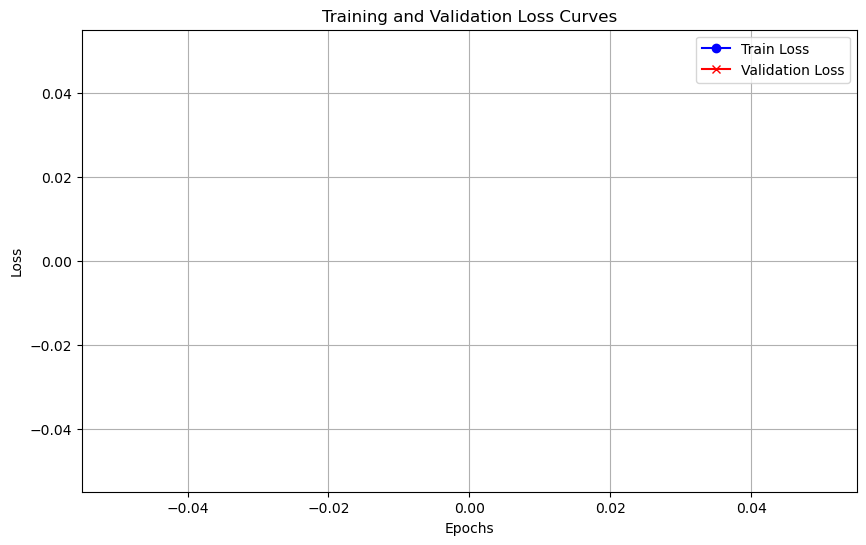

In [ ]:
# Assuming train_losses and val_losses are lists containing the loss values for each epoch
epochs = range(1, len(train_losses) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='x')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Save the plot to a file
model_name = "Art_len128_step64_10_epochs_model"  # Replace with the actual model name
filename = f"loss_curve_{model_name}.png"
plt.grid(True)
plt.savefig(filename)

# Optionally, show the plot as well
plt.show()


Authentication Process

Generate Embeddings for the Genuine Person

Take all available samples (or a representative subset) from the genuine person (user to authenticate).

Pass these samples through the feature extractor of the Siamese network to generate reference embeddings.

Test Authentication Pairs

Take samples from the second dataset (test dataset).

Pair each sample with the genuine person's data (from step 1).

Compute similarity scores for these pairs.

Apply a Threshold

Compare the similarity scores against a predefined threshold.

If the similarity score exceeds the threshold, classify the pair as "similar" (authenticated).

Otherwise, classify as "not similar" (not authenticated).

Key Considerations

Threshold Tuning:

The threshold is crucial for deciding similarity.

Use a validation dataset to tune the threshold for balancing false positives (accepting impostors) and false negatives (rejecting genuine users).

Handling Variability in Genuine Samples:

If the genuine person's data is noisy or has significant variation, consider averaging the embeddings from multiple samples to form a single, robust reference embedding.

Testing on Impostor Data:

To evaluate the system's robustness, include test pairs with genuine samples paired against impostor samples.

Measure false acceptance rate (FAR) and false rejection rate (FRR).


In [65]:
def compute_embeddings(dataloader, model, device):
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing embeddings"):
            # Extract the first element of the batch (assumed to be data tensor)
            data = batch[0]
            data = data.to(device)  # Move to device
            embedding, _ = model(data, data)  # Forward through one branch
            embeddings.append(embedding)
    return torch.cat(embeddings, dim=0)


TODO: Euclidean distance

In [75]:
def authenticate_Euclidean(model, dataloaders, threshold, device):
    """
    Authenticate using a Siamese network.
    Args:
        model: The trained Siamese network model.
        dataloaders: The DataLoader containing test data.
        threshold: The threshold for classification.
        device: The device ('cpu' or 'cuda') to run the model.
    """
    model.eval()

    # Compute embeddings for genuine and impostor datasets
    print("Processing genuine data...")
    genuine_embeddings = compute_embeddings(dataloaders['test_branch1'], model, device)
    print("Processing impostor data...")
    impostor_embeddings = compute_embeddings(dataloaders['test_branch2'], model, device)

    # Convert embeddings to tensors for pairwise distance computation
    genuine_embeddings_tensor = torch.stack(genuine_embeddings)
    impostor_embeddings_tensor = torch.stack(impostor_embeddings)

    # Compute Euclidean distance between genuine embeddings and all other genuine embeddings
    print("Computing distance scores...")
    genuine_scores = []
    impostor_scores = []

    # Compute pairwise distances between genuine embeddings
    for gen_emb in genuine_embeddings:
        gen_emb = gen_emb.unsqueeze(0)  # Add batch dimension [1, embedding_dim]
        dist = torch.cdist(gen_emb, genuine_embeddings_tensor, p=2)  # Compute Euclidean distance
        genuine_scores.extend(dist.cpu().numpy().flatten())

    # Compute pairwise distances between impostor embeddings and all genuine embeddings
    for imp_emb in impostor_embeddings:
        imp_emb = imp_emb.unsqueeze(0)  # Add batch dimension [1, embedding_dim]
        dist = torch.cdist(imp_emb, genuine_embeddings_tensor, p=2)  # Compute Euclidean distance
        impostor_scores.extend(dist.cpu().numpy().flatten())

    # Count problematic genuine samples (distances below threshold)
    problematic_genuine_count = sum(score < threshold for score in genuine_scores)
    print(f"Problematic Genuine Samples Count: {problematic_genuine_count}")

    # Count misclassified impostor samples (distances above threshold)
    misclassified_impostor_count = sum(score <= threshold for score in impostor_scores)
    print(f"Misclassified Impostor Samples Count: {misclassified_impostor_count}")

    # Calculate rates
    genuine_accepted = sum(score <= threshold for score in genuine_scores)
    impostor_rejected = sum(score > threshold for score in impostor_scores)

    GAR = genuine_accepted / len(genuine_scores) * 100
    IRR = impostor_rejected / len(impostor_scores) * 100

    print(f"Genuine Acceptance Rate: {GAR:.2f}% ({genuine_accepted}/{len(genuine_scores)})")
    print(f"Impostor Rejection Rate: {IRR:.2f}% ({impostor_rejected}/{len(impostor_scores)})")

    return GAR, IRR


In [76]:
authenticate_Euclidean(model, dataloaders, threshold=0.5, device = device)

Processing genuine data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 110.08it/s]


Processing impostor data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 125.09it/s]


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

NOW USING COSINE

In [73]:
def authenticate(model, dataloaders, threshold, device):
    """
    Authenticate using a Siamese network.
    Args:
        model: The trained Siamese network model.
        dataloaders: The DataLoader containing test data.
        threshold: The threshold for classification.
        device: The device ('cpu' or 'cuda') to run the model.
    """
    model.eval()

    # Compute embeddings for genuine and impostor datasets
    print("Processing genuine data...")
    genuine_embeddings = compute_embeddings(dataloaders['test_branch1'], model, device)
    print("Processing impostor data...")
    impostor_embeddings = compute_embeddings(dataloaders['test_branch2'], model, device)

    # Compute similarity scores between genuine embeddings and impostor embeddings
    print("Computing similarity scores...")
    genuine_scores = []
    impostor_scores = []

    for gen_emb in genuine_embeddings:
        scores = torch.cosine_similarity(gen_emb.unsqueeze(0), genuine_embeddings, dim=1)
        genuine_scores.extend(scores.cpu().numpy())
    
    for imp_emb in impostor_embeddings:
        scores = torch.cosine_similarity(imp_emb.unsqueeze(0), genuine_embeddings, dim=1)
        impostor_scores.extend(scores.cpu().numpy())
    
    # Count problematic genuine samples (scores below threshold)
    problematic_genuine_count = sum(score < threshold for score in genuine_scores)
    print(f"Problematic Genuine Samples Count: {problematic_genuine_count}")

    # Count misclassified impostor samples (scores above threshold)
    misclassified_impostor_count = sum(score >= threshold for score in impostor_scores)
    print(f"Misclassified Impostor Samples Count: {misclassified_impostor_count}")

    # Calculate rates
    genuine_accepted = sum(score >= threshold for score in genuine_scores)
    impostor_rejected = sum(score < threshold for score in impostor_scores)

    GAR = genuine_accepted / len(genuine_scores) * 100
    IRR = impostor_rejected / len(impostor_scores) * 100

    print(f"Genuine Acceptance Rate: {GAR:.2f}% ({genuine_accepted}/{len(genuine_scores)})")
    print(f"Impostor Rejection Rate: {IRR:.2f}% ({impostor_rejected}/{len(impostor_scores)})")

    return GAR, IRR


In [66]:
# Load the model from file
def load_model(model, model_path, device='cpu'):
    # Load the saved model weights
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load the state_dict (weights) into the model
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

# Path to the saved model
model_path = 'Art_len128_step64_10_epochs_model.pth'  # Replace with your actual model path

# Initialize the model
model = SiameseEEGNet(input_channels=14)

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(model, model_path, device)


In [74]:
authenticate(model, dataloaders, threshold=0.5, device = device)

Processing genuine data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 142.83it/s]


Processing impostor data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 142.76it/s]

Computing similarity scores...
Problematic Genuine Samples Count: 492
Misclassified Impostor Samples Count: 981
Genuine Acceptance Rate: 73.39% (1357/1849)
Impostor Rejection Rate: 45.68% (825/1806)


(73.39102217414819, 45.68106312292359)

For random:

In [ ]:
authenticate(model, dataloaders, threshold=0.9, device)

Processing genuine data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 100.17it/s]


Processing impostor data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 110.98it/s]

Computing similarity scores...
Sample Genuine Similarity Scores: [0.9992146492004395, 0.5514703989028931, 0.3903362452983856, 0.9988564252853394, 0.3903362452983856]
Sample Impostor Similarity Scores: [0.9797070622444153, 0.3903362452983856, 0.4973733127117157, 0.974944531917572, 0.9954725503921509]
Genuine Acceptance Rate: 100.00% (43/43)
Impostor Rejection Rate: 13.95% (6/43)


Stary model

num_epochs = 2000  # Adjust based on your needs
patience = 5
min_delta = 1e-5

previous_loss = float('inf')
epochs_without_improvement = 0
epoch_losses = [] #for plotting loss curve later

try:
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for x_batch, _ in progress_bar:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            progress_bar.set_postfix(loss=loss.item())

        average_loss = epoch_loss / len(train_dataloader)
        epoch_losses.append(average_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}')

        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save(model.state_dict(), f'enh_autoencoder_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1}.')

        # Early stopping checks
        if abs(previous_loss - average_loss) < min_delta:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1}. Loss has not improved significantly.")
                break
        else:
            epochs_without_improvement = 0

        previous_loss = average_loss

except KeyboardInterrupt:
    print("\nTraining interrupted. Saving model...")

# Save the final model after all epochs if training completes normally
torch.save(model.state_dict(), 'enh_autoencoder_final.pth')
print('Final model saved.')

from datetime import datetime
# Plot the loss curve and save it to a file
current_date = datetime.now().strftime('%Y-%m-%d')  # Get the current date as a string
filename = f"loss_curve_{current_date}.png"  # Create the filename

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.savefig(filename)  # Save the plot to a file
print(f"Loss curve saved as {filename}.")


In [ ]:
model = EnhancedAutoencoder(in_channels=in_channels)  # Initialize the model
model.load_state_dict(torch.load("enh_autoencoder_final.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully")

Model loaded successfully


In [ ]:
def calculate_reconstruction_error(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    all_inputs = []  # Store all inputs for visualization

    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in dataloader:  # No need for labels
            reconstructed = model(inputs)  # Get reconstructed output
            
            # Calculate the reconstruction error (Mean Squared Error)
            mse = torch.mean((inputs - reconstructed) ** 2, dim=[1, 2, 3])  # Mean over all dimensions
            reconstruction_errors.extend(mse.cpu().numpy())  # Store errors
            
            all_inputs.extend(inputs.cpu().numpy())  # Store original inputs

    return np.array(reconstruction_errors), np.array(all_inputs)  # Return inputs along with errors

# Call the function and get reconstruction errors and original inputs
reconstruction_errors, original_inputs = calculate_reconstruction_error(model, test_dataloader)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 1)  # E.g., 95th percentile, now 1 for testing

# Identify anomalies
anomalies = reconstruction_errors > threshold

# Print some information
print(f"Threshold for anomalies: {threshold:.4f}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")

KeyError: 0

In [ ]:
# Get indices of the detected anomalies
anomaly_indices = np.where(anomalies)[0]

# Determine the unique samples with anomalies
# Assuming each sample corresponds to a certain index in your dataset
# You can also modify this if your dataset has a different structure

# If each sample is a single time-series, use the index directly
# If each sample consists of multiple entries (e.g., 2D or 3D arrays), adjust accordingly
unique_samples_with_anomalies = set(anomaly_indices)

# Count the number of unique samples containing anomalies
num_unique_samples_with_anomalies = len(unique_samples_with_anomalies)

# Print the results
print(f"Number of unique samples containing anomalies: {num_unique_samples_with_anomalies}")

# Optionally, you can list the indices of the samples containing anomalies
print("Indices of samples with anomalies:", unique_samples_with_anomalies)


Number of unique samples containing anomalies: 5
Indices of samples with anomalies: {0, 1, 2, 3, 5}


https://en.wikipedia.org/wiki/Hamming_distance

https://en.wikipedia.org/wiki/Jaccard_index

Jaccard Similarity: Measures the similarity of the anomaly sets by comparing the intersection over the union of the anomalies.
Hamming Distance: Quantifies the difference in anomaly positions between the two samples.
These metrics help you understand how similar or different the anomaly patterns are between two random EEG samples based on your anomaly detection algorithm.

In [ ]:
# Introduce synthetic anomalies
# test_dataset.introduce_anomalies(num_anomalies=20)  # Adjust the number as needed

In [ ]:
# Function to find two samples that contain anomalies
def find_anomalous_samples(model, dataloader, threshold):
    model.eval()  # Set model to evaluation mode
    anomalous_samples = []
    indices_with_anomalies = set()  # To keep track of unique indices
    
    # Iterate over the dataloader to find samples with anomalies
    for inputs, _ in dataloader:
        with torch.no_grad():
            reconstructed = model(inputs)
        
        # Calculate reconstruction error (Mean Squared Error)
        mse = torch.mean((inputs - reconstructed) ** 2, dim=[1, 2, 3])
        
        # Convert MSE to numpy array and check for anomalies
        errors = mse.cpu().numpy()
        anomalies = errors > threshold
        
        # Append samples if they contain anomalies and are unique
        for idx in range(len(anomalies)):
            if anomalies[idx] and idx not in indices_with_anomalies:
                anomalous_samples.append(inputs[idx])
                indices_with_anomalies.add(idx)  # Track the index to avoid duplicates
            
            # Stop once we have found two unique samples with anomalies
            if len(anomalous_samples) >= 2:
                break
        
        if len(anomalous_samples) >= 2:
            break
    
    if len(anomalous_samples) < 2:
        print("Not enough anomalous samples found in the dataset.")
        return None, None
    
    # Return two unique samples with anomalies
    return anomalous_samples[0], anomalous_samples[1]

# Function to compare two anomalous samples
def compare_anomalous_samples(model, sample_1, sample_2, threshold):
    model.eval()  # Set model to evaluation mode
    
    # Forward pass through the model (no need for gradients)
    with torch.no_grad():
        reconstructed_1 = model(sample_1.unsqueeze(0))  # Add batch dimension
        reconstructed_2 = model(sample_2.unsqueeze(0))  # Add batch dimension
    
    # Calculate reconstruction errors (Mean Squared Error)
    mse_1 = torch.mean((sample_1 - reconstructed_1) ** 2, dim=[1, 2, 3])
    mse_2 = torch.mean((sample_2 - reconstructed_2) ** 2, dim=[1, 2, 3])
    
    # Convert MSE to numpy arrays
    errors_1 = mse_1.cpu().numpy()
    errors_2 = mse_2.cpu().numpy()
    
    # Determine if each sample's reconstruction error is an anomaly
    anomalies_1 = errors_1 > threshold
    anomalies_2 = errors_2 > threshold
    
    # Jaccard similarity (intersection over union)
    jaccard_sim = jaccard_score(anomalies_1, anomalies_2, average='binary')
    
    # Hamming distance (number of different positions)
    hamming_dist = hamming_loss(anomalies_1, anomalies_2)
    
    return jaccard_sim, hamming_dist

# Main logic: find and compare anomalous samples
sample_1, sample_2 = find_anomalous_samples(model, test_dataloader, threshold)

if sample_1 is not None and sample_2 is not None:
    jaccard_similarity, hamming_distance = compare_anomalous_samples(model, sample_1, sample_2, threshold)
    
    print(f"Jaccard Similarity: {jaccard_similarity:.4f}")
    print(f"Hamming Distance: {hamming_distance:.4f}")


Jaccard Similarity: 1.0000
Hamming Distance: 0.0000


A Jaccard similarity of 1.0000 and a Hamming distance of 0.0000 indicates that the two samples are identical in terms of their detected anomalies. This means that both samples have the same anomalies at the same positions.

Next Steps
Here are a few suggestions for what you could do next:

Visualize Anomalous Samples: Consider visualizing both anomalous samples to better understand what the anomalies look like. This can help in diagnosing issues or confirming that the detected anomalies are indeed valid.

Analyze Reconstruction Errors: Investigate the reconstruction errors for different samples, especially those not classified as anomalies. This can give insights into the model's performance.

Experiment with Thresholds: You could experiment with different thresholds for anomaly detection to see how it affects the number of detected anomalies. This can help fine-tune your anomaly detection system.

Add More Evaluation Metrics: Depending on your needs, you might want to compute additional metrics, such as precision, recall, or F1-score, if you have ground truth labels for anomalies.

Test on New Data: If possible, try applying your model to new data to evaluate its generalization performance and see if it effectively identifies anomalies.

Train with More Data: If your dataset is limited, consider gathering more training data or using data augmentation techniques to improve the model's performance.

Shape of image at index 0: (19, 30999, 1)
Shape of image at index 1: (19, 30999, 1)
Shape of image at index 2: (19, 30999, 1)
Shape of image at index 3: (19, 30999, 1)
Shape of image at index 5: (19, 30999, 1)


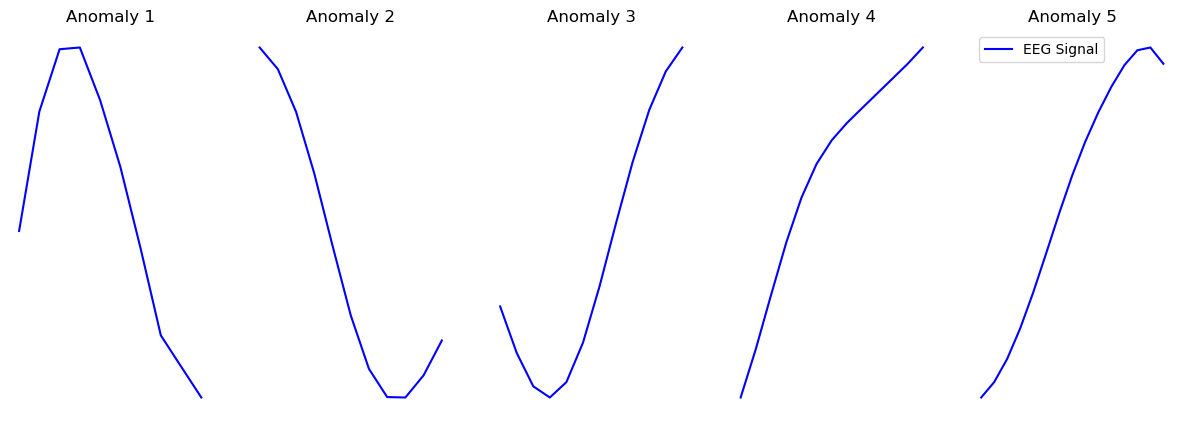

In [ ]:
# Visualize the detected anomalies 
anomaly_indices = np.where(anomalies)[0]
n_samples = min(5, len(anomaly_indices))  # Show at most 5 samples

# Create a figure for visualization
plt.figure(figsize=(15, 5))
for i, index in enumerate(anomaly_indices[:n_samples]):
    plt.subplot(1, n_samples, i + 1)
    plt.title(f'Anomaly {i + 1}')
    
    # Extract the anomalous image
    image = original_inputs[index]

    # Print the shape of the image for debugging
    print(f"Shape of image at index {index}: {image.shape}")

    # Selecting the first channel for visualization (adjust if needed)
    image = image[0, :, :]  # Select the first channel (shape: [30999, 1])

    # Check if there's a singleton dimension, and squeeze it
    if image.ndim == 2 and image.shape[1] == 1:
        image = image.squeeze(1)  # Remove the second dimension

    # Determine the time slice around the anomaly
    anomaly_position = index
    start = max(0, anomaly_position - 10)  # 100 points before the anomaly
    end = min(anomaly_position + 10, len(image))  # 100 points after the anomaly

    # Adjust the start index if we don't have 100 points before the anomaly
    if anomaly_position < 10:
        start = 0  # Ensure we start at the beginning if not enough points before
    # Adjust the end index if we don't have 100 points after the anomaly
    if anomaly_position + 10 >= len(image):
        end = len(image)  # Ensure we end at the last point if not enough points after
    
    # Ensure we are within bounds
    time_slice = slice(start, end)  # Get the slice for visualization
    image_slice = image[time_slice]  # Extract the relevant slice

    # Plot the entire slice in blue
    plt.plot(image_slice, color='blue', label='EEG Signal')  # Use plot for one-dimensional data

    # Color the segments of the signal corresponding to the anomalies
    for anomaly in np.where(anomalies[start:end])[0]:  # Iterate through the anomalies in the slice
        plt.plot(np.arange(anomaly + start, anomaly + start + 1), image_slice[anomaly], color='red', linewidth=2)

    plt.axis('off')  # Hide axes
plt.legend()  # Show legend
plt.show()


Shape of image at index 0: (19, 30999, 1)
Shape of image at index 1: (19, 30999, 1)
Shape of image at index 2: (19, 30999, 1)
Shape of image at index 3: (19, 30999, 1)
Shape of image at index 5: (19, 30999, 1)


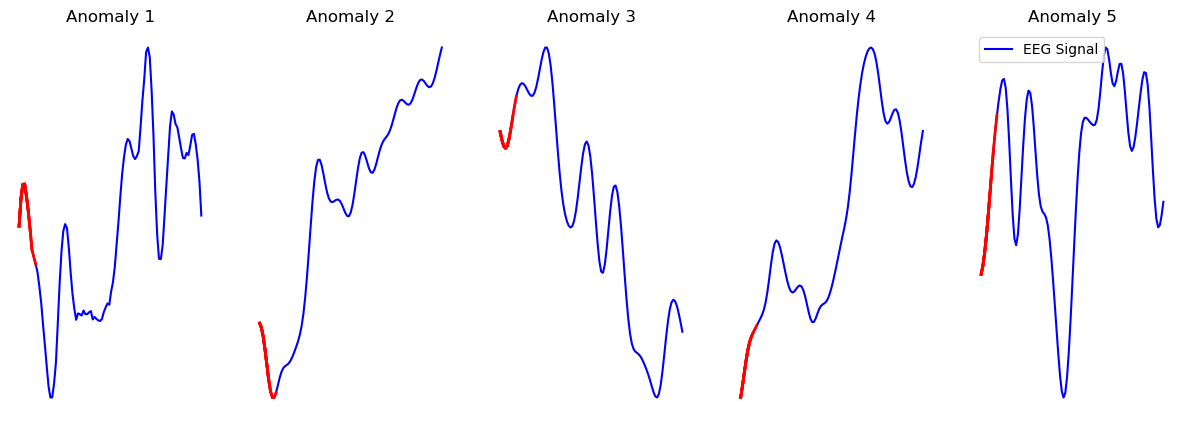

In [ ]:
# Visualize the detected anomalies 
anomaly_indices = np.where(anomalies)[0]
n_samples = min(5, len(anomaly_indices))  # Show at most 5 samples

# Create a figure for visualization
plt.figure(figsize=(15, 5))
for i, index in enumerate(anomaly_indices[:n_samples]):
    plt.subplot(1, n_samples, i + 1)
    plt.title(f'Anomaly {i + 1}')
    
    # Extract the anomalous image
    image = original_inputs[index]

    # Print the shape of the image for debugging
    print(f"Shape of image at index {index}: {image.shape}")

    # Selecting the first channel for visualization (adjust if needed)
    image = image[0, :, :]  # Select the first channel (shape: [30999, 1])

    # Check if there's a singleton dimension, and squeeze it
    if image.ndim == 2 and image.shape[1] == 1:
        image = image.squeeze(1)  # Remove the second dimension

    # Determine the time slice around the anomaly
    anomaly_position = index
    start = max(0, anomaly_position - 100)  # 10 points before the anomaly
    end = min(anomaly_position + 100, len(image))  # 10 points after the anomaly

    # Adjust the start index if we don't have enough points before the anomaly
    if anomaly_position < 100:
        start = 0  # Ensure we start at the beginning if not enough points before
    # Adjust the end index if we don't have enough points after the anomaly
    if anomaly_position + 100 >= len(image):
        end = len(image)  # Ensure we end at the last point if not enough points after

    # Ensure we are within bounds
    time_slice = slice(start, end)  # Get the slice for visualization
    image_slice = image[time_slice]  # Extract the relevant slice

    # Plot the entire slice in blue
    plt.plot(image_slice, color='blue', label='EEG Signal')  # Use plot for one-dimensional data

    # Color the segments of the signal corresponding to the anomalies
    for anomaly in np.where(anomalies[start:end])[0]:  # Iterate through the anomalies in the slice
        # Define the segment for the anomaly
        anomaly_start = max(0, anomaly + start - 5)  # Extend segment start slightly before anomaly
        anomaly_end = min(len(image_slice), anomaly + start + 5)  # Extend segment end slightly after anomaly
        plt.plot(np.arange(anomaly_start, anomaly_end), image[anomaly_start:anomaly_end], color='red', linewidth=2)

    plt.axis('off')  # Hide axes
plt.legend()  # Show legend
plt.show()


1. Prepare the Test Data:
The test set will consist of pairs of recordings:

Positive pairs: Two recordings from the same person (e.g., Artlog1 and Artlog2 for the same person).
Negative pairs: Two recordings from different people (e.g., Artlog1 and Tym1, where Art and Tym are different people).
These pairs are used to test whether the network can correctly classify them as either similar or dissimilar.

2. Define a Function for Similarity Measurement:
After training, the Siamese network will output a similarity score (usually between 0 and 1). You will need to define a threshold for what constitutes a "match" (same person) or "non-match" (different person). Typically, a lower score indicates dissimilarity, and a higher score indicates similarity.

You can use a cosine similarity, Euclidean distance, or contrastive loss output (depending on how you designed the network) to measure this similarity.

For example, if the network outputs a similarity score, a common way to classify the pair is:

Similarity Score ≥ threshold: Same person (positive pair)
Similarity Score < threshold: Different person (negative pair)
3. Evaluate the Network:
The goal is to test how well your network is performing. You’ll calculate metrics such as:

Accuracy: Proportion of correct classifications (positive and negative pairs).
Precision, Recall, and F1-Score: Especially useful when you have imbalanced data (e.g., fewer negative pairs).
ROC Curve and AUC (Area Under Curve): To visualize how well your model can differentiate between similar and dissimilar pairs at different thresholds.

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve

def test_siamese_network(model, test_pairs, threshold=0.5):
    """
    Test the Siamese network using the test pairs.
    
    Parameters:
    - model: Trained Siamese network.
    - test_pairs: List of tuples (pair1, pair2, label) where:
        - pair1 and pair2 are the two input data points (e.g., EEG windows),
        - label is 1 for similar (same person) or 0 for dissimilar (different person).
    - threshold: Similarity threshold for deciding positive or negative pair.
    
    Returns:
    - accuracy: The accuracy of the model on the test set.
    - auc: The AUC (Area Under Curve) for the ROC curve.
    """
    
    all_preds = []
    all_labels = []
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for pair1, pair2, label in test_pairs:
            # Get embeddings for both inputs
            output1, output2 = model(pair1, pair2)
            
            # Calculate the distance or similarity score (e.g., Euclidean distance)
            distance = torch.norm(output1 - output2, p=2, dim=1)  # Euclidean distance
            similarity_score = 1 / (1 + distance)  # Convert to similarity score [0, 1]
            
            # Classify the pair based on the similarity score
            pred = (similarity_score >= threshold).float()  # 1 for similar, 0 for dissimilar
            
            # Append the predicted and true labels
            all_preds.append(pred.item())
            all_labels.append(label)
    
    # Calculate accuracy, precision, recall, and AUC
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    
    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return accuracy, auc, precision, recall

# Example usage:
test_pairs = [
    # (pair1, pair2, label)
    (pair1_data, pair2_data, 1),  # 1 means same person (positive pair)
    (pair1_data, pair3_data, 0),  # 0 means different person (negative pair)
    # Add more test pairs...
]

accuracy, auc, precision, recall = test_siamese_network(model, test_pairs)


Accuracy: Shows the proportion of correctly classified pairs. However, if your test set is imbalanced (e.g., more positive pairs than negative), accuracy may not be a good indicator of model performance.

AUC (Area Under ROC Curve): Measures the ability of the model to discriminate between positive and negative pairs at various thresholds. A higher AUC indicates better performance.

Precision-Recall Curve: Useful when dealing with imbalanced datasets, as it shows how well the model performs with respect to both positive and negative classes.

In [ ]:
def aggregate_window_comparisons(window_pairs, threshold=0.5):
    """
    Aggregate results from multiple window comparisons.
    
    Parameters:
    - window_pairs: List of tuples (window1, window2, label) where:
        - window1 and window2 are EEG windows,
        - label is 1 for same person or 0 for different person.
    - threshold: Similarity threshold for classifying the pair.
    
    Returns:
    - final_pred: Aggregated prediction (1 for same person, 0 for different person).
    """
    similarities = []
    
    for window1, window2, label in window_pairs:
        similarity_score = compare_two_windows(window1, window2)
        similarities.append(similarity_score)
    
    # Average similarity score across all windows
    average_similarity = np.mean(similarities)
    
    # Classify based on average similarity score
    final_pred = 1 if average_similarity >= threshold else 0
    return final_pred

def compare_two_windows(window1, window2):
    # Compare two windows and return similarity score
    # This could be using Euclidean distance, cosine similarity, etc.
    distance = np.linalg.norm(window1 - window2)
    similarity_score = 1 / (1 + distance)
    return similarity_score